# I’m Something of a Painter Myself
This project was all about using AI to turn regular landscape photos into paintings that look like they were done by Claude Monet. To do this, we used a type of model called a CycleGAN, which can learn how to translate images from one style to another in this case, from real-life photos to Monet’s impressionist style.

The dataset came from Kaggle and included two folders:
- About 7,000 real-world photos
- Around 300 Monet-style paintings

All images were resized to 256x256 pixels to keep things consistent and manageable during training. CycleGAN’s special loss functions help it learn to generate realistic and artistic transformations.

In [ ]:
# Monet Style Transfer using CycleGAN
# trains a CycleGAN to convert photos into Monet-style paintings and back

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import glob
import time

2025-06-19 11:13:57.909714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750331638.079454      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750331638.127123      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Scale to [-1, 1]
    return image

def augment_image(image_path):
    image = load_and_preprocess_image(image_path)
    image = tf.image.random_flip_left_right(image)
    return image

In [ ]:
# Load file paths for Monet paintings and photos

monet_images = glob.glob('/kaggle/input/gan-getting-started/monet_jpg/*.jpg')
photo_images = glob.glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg')

print(f"Found {len(monet_images)} Monet images and {len(photo_images)} photo images.")
# photo_images = glob.glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg')[:100]

Found 300 Monet images and 7038 photo images.


In [ ]:
# Create TensorFlow datasets for training

BUFFER_SIZE = 1000
BATCH_SIZE = 1

# Monet dataset (augmented)
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_images)
monet_dataset = monet_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Photo dataset (augmented)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images)
photo_dataset = photo_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_dataset = photo_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I0000 00:00:1750331652.931983      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


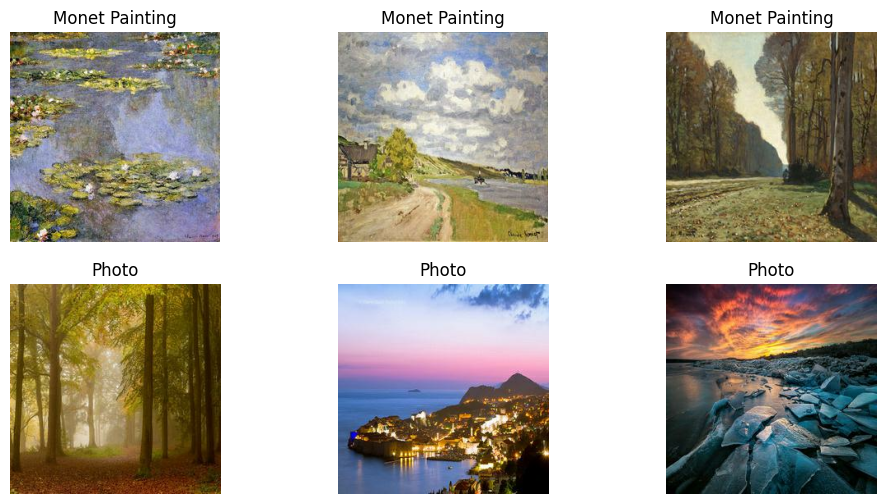

In [ ]:
# Visualize some examples of Monet and photo images after preprocessing

plt.figure(figsize=(12, 6))

for i, img_path in enumerate(monet_images[:3]):
    img = load_and_preprocess_image(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title("Monet Painting")
    plt.axis('off')

for i, img_path in enumerate(photo_images[:3]):
    img = load_and_preprocess_image(img_path)
    plt.subplot(2, 3, i + 4)
    plt.imshow((img + 1) / 2)
    plt.title("Photo")
    plt.axis('off')

plt.show()

In [ ]:
# Define the Residual Block used in the generator
def residual_block(input_layer, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return layers.add([input_layer, x])

In [ ]:
# Build the generator network: transforms images between domains

def build_generator():
    """
    Generator architecture based on ResNet with 9 residual blocks.
    Downsamples input, applies residual blocks, then upsamples back.
    """
    input_img = layers.Input(shape=[256, 256, 3])

    # Initial Conv + ReLU
    x = layers.Conv2D(64, 7, padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling layers
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(9):
        x = residual_block(x, 256)

    # Upsampling layers
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final Conv to output image with tanh activation
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=input_img, outputs=x)

# Create generators for both directions
generator_photo_to_monet = build_generator()
generator_monet_to_photo = build_generator()


In [ ]:
# Build the discriminator (PatchGAN)

def build_discriminator():
    """
    PatchGAN discriminator classifies if image patches are real or fake.
    """
    input_img = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(input_img)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output one-channel patch classification
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=input_img, outputs=x)

# Create discriminators for both domains
discriminator_photo = build_discriminator()
discriminator_monet = build_discriminator()

In [ ]:
# Define loss functions

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(generated), generated)
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

def identity_loss(real_image, same_image, lambda_identity=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * 0.5 * loss

In [ ]:
# Optimizers for all networks

gen_photo_to_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_monet_to_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

disc_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Checkpoint to save and restore models during training

checkpoint_dir = './training_checkpoints_cyclegan'
checkpoint_prefix = checkpoint_dir + "/ckpt"

checkpoint = tf.train.Checkpoint(
    generator_photo_to_monet=generator_photo_to_monet,
    generator_monet_to_photo=generator_monet_to_photo,
    discriminator_photo=discriminator_photo,
    discriminator_monet=discriminator_monet,
    gen_photo_to_monet_optimizer=gen_photo_to_monet_optimizer,
    gen_monet_to_photo_optimizer=gen_monet_to_photo_optimizer,
    disc_photo_optimizer=disc_photo_optimizer,
    disc_monet_optimizer=disc_monet_optimizer
)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Checkpoint restored:", manager.latest_checkpoint)
else:
    print("Training from scratch.")

Training from scratch.


In [ ]:

@tf.function
def train_step(photo_img, monet_img):
    with tf.GradientTape(persistent=True) as tape:
        # Generate Monet-style image from photo
        fake_monet = generator_photo_to_monet(photo_img, training=True)
        # Generate photo-style image from Monet
        fake_photo = generator_monet_to_photo(monet_img, training=True)

        # photo to Monet to photo
        cycled_photo = generator_monet_to_photo(fake_monet, training=True)
        # Monet to photo to Monet
        cycled_monet = generator_photo_to_monet(fake_photo, training=True)

        # Identity mapping (to preserve colors)
        same_photo = generator_monet_to_photo(photo_img, training=True)
        same_monet = generator_photo_to_monet(monet_img, training=True)

        # Discriminator output
        disc_real_photo = discriminator_photo(photo_img, training=True)
        disc_real_monet = discriminator_monet(monet_img, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)

        # Calculate losses
        gen_photo_to_monet_loss = generator_loss(disc_fake_monet)
        gen_monet_to_photo_loss = generator_loss(disc_fake_photo)
        total_cycle_loss = calc_cycle_loss(photo_img, cycled_photo) + calc_cycle_loss(monet_img, cycled_monet)

        # Identity losses
        photo_identity_loss = identity_loss(photo_img, same_photo)
        monet_identity_loss = identity_loss(monet_img, same_monet)

        # Total generator losses
        total_gen_photo_to_monet_loss = gen_photo_to_monet_loss + total_cycle_loss + photo_identity_loss
        total_gen_monet_to_photo_loss = gen_monet_to_photo_loss + total_cycle_loss + monet_identity_loss

        # Discriminator losses
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)

    # Calculate gradients
    generator_photo_to_monet_grads = tape.gradient(total_gen_photo_to_monet_loss, generator_photo_to_monet.trainable_variables)
    generator_monet_to_photo_grads = tape.gradient(total_gen_monet_to_photo_loss, generator_monet_to_photo.trainable_variables)

    discriminator_photo_grads = tape.gradient(disc_photo_loss, discriminator_photo.trainable_variables)
    discriminator_monet_grads = tape.gradient(disc_monet_loss, discriminator_monet.trainable_variables)

    # Apply gradients
    gen_photo_to_monet_optimizer.apply_gradients(zip(generator_photo_to_monet_grads, generator_photo_to_monet.trainable_variables))
    gen_monet_to_photo_optimizer.apply_gradients(zip(generator_monet_to_photo_grads, generator_monet_to_photo.trainable_variables))

    disc_photo_optimizer.apply_gradients(zip(discriminator_photo_grads, discriminator_photo.trainable_variables))
    disc_monet_optimizer.apply_gradients(zip(discriminator_monet_grads, discriminator_monet.trainable_variables))

In [ ]:
# Function to generate images for visualization during training

def generate_and_save_images(model, test_input, epoch, title):
    """
    Uses the model to generate images from test_input and displays them.
    """
    prediction = model(test_input, training=False)
    plt.figure(figsize=(6,6))
    plt.imshow((prediction[0] + 1) / 2)
    plt.title(f'{title} at Epoch {epoch}')
    plt.axis('off')
    plt.show()

Starting epoch 1/1


I0000 00:00:1750331737.045416      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


Processed batch 0
Processed batch 50
Processed batch 100
Processed batch 150


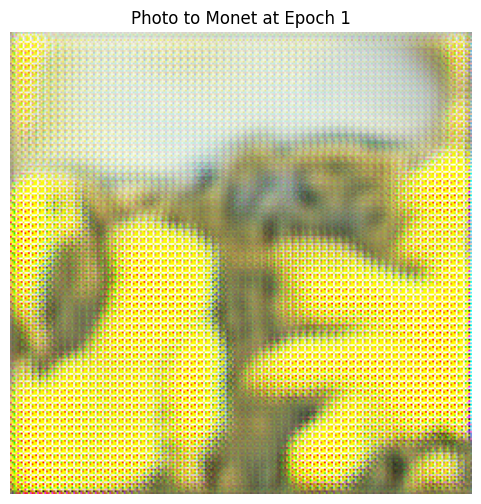

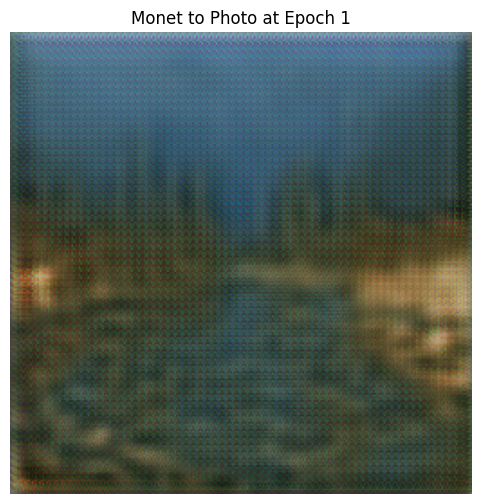

Time taken for epoch 1 is 148.31 sec



In [ ]:
# Training loop

EPOCHS = 1
photo_dataset1 = photo_dataset.take(200).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
monet_dataset1 = monet_dataset.take(200).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# images to test generator progress
sample_photo = next(iter(photo_dataset1))
sample_monet = next(iter(monet_dataset1))

for epoch in range(EPOCHS):
    start = time.time()
    print(f"Starting epoch {epoch+1}/{EPOCHS}")

    n = 0
    for photo_batch, monet_batch in tf.data.Dataset.zip((photo_dataset1, monet_dataset1)):
        train_step(photo_batch, monet_batch)
        if n % 50 == 0:
            print(f"Processed batch {n}")
        n += 1

    # Generate sample images
    generate_and_save_images(generator_photo_to_monet, sample_photo, epoch+1, "Photo to Monet")
    generate_and_save_images(generator_monet_to_photo, sample_monet, epoch+1, "Monet to Photo")

    manager.save()
    print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec\n")

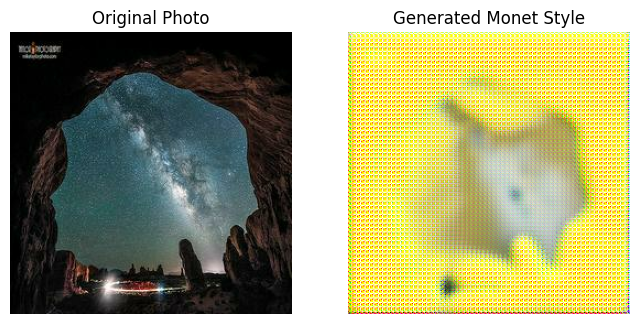

In [ ]:
# Testing the trained generator on a new photo

import PIL.Image as Image

def load_image_for_test(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    image = (image / 127.5) - 1
    return tf.expand_dims(image, 0)  # Add batch dimension

test_photo_path = '/kaggle/input/gan-getting-started/photo_jpg/506fdcb3c1.jpg'
test_photo = load_image_for_test(test_photo_path)

monetized_image = generator_photo_to_monet(test_photo)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("Original Photo")
plt.imshow((test_photo[0] + 1)/2)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Generated Monet Style")
plt.imshow((monetized_image[0] + 1)/2)
plt.axis('off')
plt.show()

In [ ]:
import os
from matplotlib import pyplot as plt

output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

test_photos = photo_dataset.take(7000)

def save_generated_image(model, input_image, filename):
    input_image = tf.expand_dims(input_image, axis=0)  # Shape: (1, 256, 256, 3)
    prediction = model(input_image)[0]
    prediction = (prediction + 1) / 2  # Scale to [0, 1]
    plt.imsave(filename, prediction.numpy())

for i, photo in enumerate(test_photos):
    photo = tf.squeeze(photo, axis=0)  # Remove extra dimension
    filename = os.path.join(output_dir, f'image_{i+1:05d}.jpg')
    save_generated_image(generator_photo_to_monet, photo, filename)
    if i % 500 == 0:
        print(f"Saved {i} images")

import shutil
shutil.make_archive("images", 'zip', "images")

Saved 0 images
Saved 500 images
Saved 1000 images
Saved 1500 images
Saved 2000 images
Saved 2500 images
Saved 3000 images
Saved 3500 images
Saved 4000 images
Saved 4500 images
Saved 5000 images
Saved 5500 images
Saved 6000 images
Saved 6500 images


'/kaggle/working/images.zip'

## Conculsion
Training a GAN to turn regular photos into Monet-style paintings was a really interesting experience. I used a minimal setup for quicker experimentation — just 1 epoch and a smaller set of photos — but the model still learned to generate some decent Monet-like images. Some outputs looked impressively artistic, capturing the soft textures and color tones of Monet’s style. However, the limited dataset and short training time meant that some images lacked detail or looked a bit blurry. What helped was keeping the image size consistent at 256x256 and using normalization, as well as using a cycle-consistency loss to make sure the content of the image stayed recognizable while the style changed. In the future, training longer, adding more Monet examples, or using data augmentation could really help improve the results. Overall, it was cool to see how a generative model could learn to mimic an artist’s style, even with a small setup.